In [11]:
import os
import re
#import ROOT
import hist
import pickle
import mplhep as hep
from glob import glob
import numpy as np
import awkward as ak
from tabulate import tabulate
from IPython import embed
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
hep.style.use("CMS")
print("iminuit version:", iminuit.__version__)
import itertools
from collections import defaultdict
import glob

iminuit version: 2.30.1


Saved .pickle file: INPUT/invm_masses/gen/combined_pickles
Saved .pickle file: INPUT/invm_masses/gen/combined_pickles
Saved .pickle file: INPUT/invm_masses/gen/combined_pickles
Saved .pickle file: INPUT/invm_masses/reco/combined_pickles
Saved .pickle file: INPUT/invm_masses/reco/combined_pickles
Saved .pickle file: INPUT/invm_masses/reco/combined_pickles
Saved .pickle file: INPUT/invm_masses/fastMTT/combined_pickles
Saved .pickle file: INPUT/invm_masses/fastMTT/combined_pickles
Saved .pickle file: INPUT/invm_masses/fastMTT/combined_pickles
gen file :  INPUT/invm_masses/gen/combined_pickles/gen_1_hist__GenHiggs_mass.pickle
gen file :  INPUT/invm_masses/gen/combined_pickles/gen_2_hist__GenHiggs_mass.pickle
gen file :  INPUT/invm_masses/gen/combined_pickles/gen_3_hist__GenHiggs_mass.pickle
reco file :  INPUT/invm_masses/reco/combined_pickles/hist__hcand_invm_reco_2.pickle
reco file :  INPUT/invm_masses/reco/combined_pickles/hist__hcand_invm_reco_3.pickle
reco file :  INPUT/invm_masses/rec

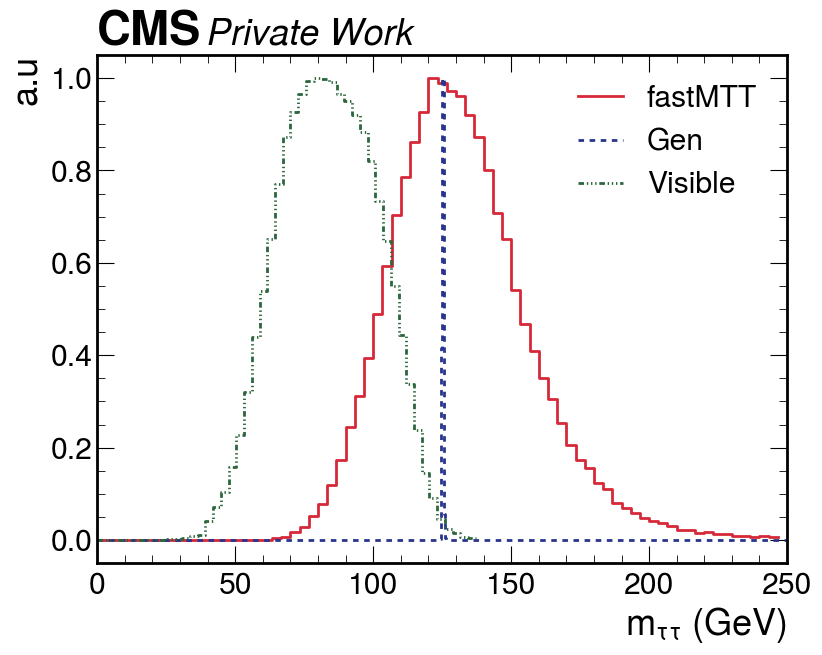

In [12]:
## Define the categories and tags
tags = ["IPPV"]

catdict = {
    r"$\mu a^{3\pi}_{1}$" : 20014008,
}

shiftdict = {
    "gen": {"shift": 0, "colour": "#d62839", "location": "upper right", "linestyle": "solid"},
    "reco": {"shift": 0, "colour": "#28348e", "location": "lower left", "linestyle": (0, (2, 2))},
    "fastMTT": {"shift": 0, "colour": "#2b663c", "location": "lower right", "linestyle":(0, (2, 1, 0.5, 1, 0.5, 1, 0.5, 1))},
}

simpledict = {
    r"$\mu a^{3\pi}_{1}$" : "mua13pr",
}

## Combine the Pickle files if needed
dir_name = "invm_masses"

subdirs = [
    "gen",
    "reco",
    "fastMTT"
]

# Kombinieren und speichern der Pickle-Daten für alle Unterverzeichnisse
for subdir in subdirs:
    base_dir = os.path.join("INPUT", f"{dir_name}/{subdir}")
    place_combined_pickels = os.path.join(base_dir, "combined_pickles")
    output_dir = os.path.join("OUTPUT", f"{dir_name}/{subdir}")
    os.makedirs(place_combined_pickels, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

    file_names = set(os.path.basename(f) for f in glob.glob(os.path.join(base_dir, "*.pickle")))

    for file_name in file_names:
        combined_hist = None

        # Kombiniere die Daten aus den Pickle-Dateien für dieses Subverzeichnis
        for subdir in subdirs:
            file_path = os.path.join(base_dir, file_name)
            
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            
            if combined_hist is None:
                combined_hist = data
            else:
                combined_hist += data
        
        # Speichern der kombinierten Pickle-Datei
        output_path = os.path.join(place_combined_pickels, file_name)
        with open(output_path, 'wb') as f:
            pickle.dump(combined_hist, f)

        print(f"Saved .pickle file: {place_combined_pickels}")

# Ein einzelnes Dictionary für alle Datensätze
datasets = {
    "fastMTT": {
        "mass_axis_name": "hcand_invm_fastMTT",
        "color": "#d62839",
        "linestyle": "solid",  
        "data": None  
    },
    "Gen": {
        "mass_axis_name": "GenHiggs_mass",
        "color": "#28348e",
        "linestyle": (0, (2, 2)),  
        "data": None
    },
    "Reco": {
        "mass_axis_name": "hcand_invm",
        "color": "#2b663c",
        "linestyle": (0, (2, 1, 0.5, 1, 0.5, 1, 0.5, 1)),
        "data": None
    }
}

# Base directory und Liste der Pickle-Dateien
# Base directory and list of Pickle files from all 'combined_pickles' directories
file_list = []
for subdir in subdirs:
    combined_files_path = os.path.join("INPUT", dir_name, subdir, "combined_pickles", "*.pickle")
    file_list.extend(glob.glob(combined_files_path))


# Laden und Zuweisen der Daten aus den Pickle-Dateien
for file in file_list:
    if "sig" in file:
        key = "fastMTT"
        print("sig file : ", file)
    elif "gen" in file.lower():
        key = "Gen"
        print("gen file : ", file)
    else:
        key = "Reco"
        print("reco file : ", file)
    
    mass_axis_name = datasets[key]["mass_axis_name"]
    color = datasets[key]["color"]
    
    with open(file, 'rb') as fileptr:
        data = pickle.load(fileptr)
    
    if mass_axis_name not in [axis.name for axis in data.axes]:
        print(f"Warning: Expected mass axis '{mass_axis_name}' not found in {key} data. Skipping...")
        continue
    
    datasets[key]["data"] = data  # Daten im Dictionary speichern

# Kombinieren der Daten für alle is_gen-Flags
for key, info in datasets.items():
    if info["data"] is None:
        continue  # Wenn keine Daten vorhanden sind, überspringen

    # Falls mehrere Dateien existieren, kombinieren wir sie
    for file in file_list:
        if key in file:
            with open(file, 'rb') as fileptr:
                data = pickle.load(fileptr)
                datasets[key]["data"] = data  # Kombiniere die Hist-Daten

# Mapping für alternative Legendenbeschriftungen
legend_labels = {
    "Reco": "Visible",
    "Gen": "Gen",
    "fastMTT": "fastMTT"
}

# Plotten der kombinierten Histogramme
fig, ax = plt.subplots(figsize=(8.9, 6.6))
hep.cms.text("Private Work", loc=0)

line_width = 2
legend_line_width = line_width

for key, info in datasets.items():
    data = info["data"]
    
    if data is None:
        print(f"WARNING: No data available for {key}")
        continue
    
    mass_axis_name = info["mass_axis_name"]
    
    # Finden des Indexes des mass_axis_name
    mass_axis_idx = None
    for i, axis in enumerate(data.axes):
        if axis.name == mass_axis_name:
            mass_axis_idx = i
            break
    
    if mass_axis_idx is None:
        print(f"Warning: Mass axis '{mass_axis_name}' not found in {key} data. Skipping...")
        continue
    
    # Projektion auf die Mass-Achse durch Übergabe des Indexes
    mass_hist = data.project(mass_axis_idx)  
    
    bin_edges = mass_hist.axes[0].edges  # Bin-Kanten für die Masse
    counts = mass_hist.view().value  # Bin-Inhalte (y-Werte)

    # Normalisierung der Histogramme
    counts = counts / max(counts)  # Normalisiere auf maximalen Wert
    
    # Verwende den angepassten Legendentext
    ax.step(bin_edges[:-1], counts, where='post', color=info["color"], linestyle=info["linestyle"], linewidth=line_width, label=legend_labels.get(key, key))

# Achsenbeschriftungen und Legende
ax.set_xlim(0, 250)
ax.set_xlabel("$m_{\\tau \\tau}$ (GeV)")
ax.set_ylabel("a.u")  # Allgemeine Beschriftung für die Y-Achse
leg = ax.legend()  # Create the legend
for line in leg.get_lines():  # Iterate through the legend lines
    line.set_linewidth(legend_line_width)
plt.savefig("OUTPUT/Common_plot_invm.pdf", dpi=300, bbox_inches='tight')

plt.show()
